In [40]:
# Necessary imports
import glob
import pandas as pd
import urllib.request
import imageio
import os
import IPython
import numpy as np
# Imports
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from urllib.request import urlopen

In [39]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-200')

In [17]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 200

# Configuration
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")



Will generate 64px square images.


In [4]:
caption_embeddings = np.load('D:/Text-to-Image-Using-GAN-master/Data/datasets/flowers/text_c10/caption_embeddings.npy')
print(caption_embeddings.shape)
image_binary_path = "D:/Text-to-Image-Using-GAN-master/Data/datasets/flowers/images/npy64/"
images = os.listdir(image_binary_path)

(8189, 200)


In [5]:
caption_embeddings = np.load('D:/Text-to-Image-Using-GAN-master/Data/datasets/flowers/text_c10/caption_embeddings.npy')
print(caption_embeddings.shape)
image_binary_path = "D:/Text-to-Image-Using-GAN-master/Data/datasets/flowers/images/npy64/"
images = os.listdir(image_binary_path)

(8189, 200)


In [6]:
# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
    try:
        final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
    except:
        pass
    
print(final_images.shape)

(8100, 128, 128, 3)


In [20]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]
caption_embeddings.shape

(8100, 200)

## GAN

tf.Tensor([[0.5021028]], shape=(1, 1), dtype=float32)


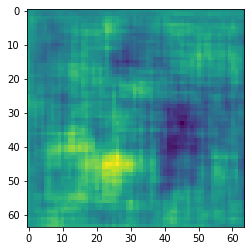

In [32]:
def build_generator_func_gan(seed_size, embedding_size, channels):
    input_seed = Input(shape=seed_size)
    input_embed = Input(shape = embedding_size)
    d0 = Dense(128)(input_embed)
    leaky0 = LeakyReLU(alpha=0.2)(d0)

    merge = Concatenate()([input_seed, leaky0])

    d1 = Dense(4*4*256,activation="relu")(merge)
    reshape = Reshape((4,4,256))(d1)

    upSamp1 = UpSampling2D()(reshape)
    conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
    batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
    leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

    upSamp2 = UpSampling2D()(leaky1)
    conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
    batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
    leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

    upSamp3 = UpSampling2D()(leaky2)
    conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
    batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
    leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

    upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
    conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
    batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
    leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

    outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
    outputActi = Activation("tanh")(outputConv)

    model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
    return model

def build_discriminator_func_gan(image_shape, embedding_size):
    input_shape = Input(shape=image_shape)
    input_embed = Input(shape=embedding_size)

    conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
    leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

    drop2 = Dropout(0.25)(leaky1)
    conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
    # zero2 = ZeroPadding2D(padding=((0,1),(0,1)))(conv2d2)
    batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
    leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

    drop3 = Dropout(0.25)(leaky2)
    conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
    batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
    leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

    drop4 = Dropout(0.25)(leaky3)
    conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
    batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
    leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

    dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
    leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
    reshape_embed = Reshape((4,4,8))(leaky_embed)
    merge_embed = Concatenate()([leaky4, reshape_embed])

    drop5 = Dropout(0.25)(merge_embed)
    conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
    batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
    leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

    drop6 = Dropout(0.25)(leaky5)
    flatten = Flatten()(drop6)
    output = Dense(1,activation="sigmoid")(flatten)

    model = Model(inputs=[input_shape,input_embed], outputs=output)
    return model

# Initlializing a generator
generator1 = build_generator_func_gan(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator1((noise,caption_embeddings[5].reshape(1,200)), training=False)
plt.imshow(generated_image[0, :, :, 0])

# Initlializing a discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
discriminator1 = build_discriminator_func_gan(image_shape,EMBEDDING_SIZE)

decision = discriminator1((generated_image,caption_embeddings[5].reshape(1,200)))
print(decision)

## AttnGAN

tf.Tensor([[0.50341576]], shape=(1, 1), dtype=float32)


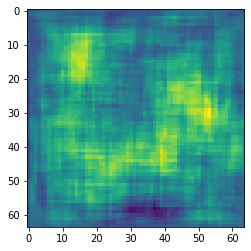

In [33]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import initializers

class SelfAttention(Layer):
    def __init__(self, channels, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = channels
        self.theta = Conv2D(channels // 8, kernel_size=1, use_bias=False)
        self.phi = Conv2D(channels // 8, kernel_size=1, use_bias=False)
        self.g = Conv2D(channels // 2, kernel_size=1, use_bias=False)
        self.o_conv = Conv2D(channels, kernel_size=1, use_bias=False)
        self.gamma = self.add_weight(name='gamma', shape=[], initializer='zeros', trainable=True)

    def call(self, x):
        batch_size, height, width, channels = x.shape
        theta = self.theta(x)
        phi = self.phi(x)
        g = self.g(x)

        theta = Reshape((-1, channels // 8))(theta)
        phi = Reshape((-1, channels // 8))(phi)
        g = Reshape((-1, channels // 2))(g)

        f = tf.matmul(theta, phi, transpose_b=True)
        f = tf.nn.softmax(f)

        o = tf.matmul(f, g)
        o = Reshape((height, width, channels // 2))(o)
        o = self.o_conv(o)

        x = self.gamma * o + x
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'channels': self.channels
        })
        return config

    
    
def build_generator_func_attn(seed_size, embedding_size, channels):
    input_seed = Input(shape=seed_size)
    input_embed = Input(shape=embedding_size)
    
    d0 = Dense(128)(input_embed)
    leaky0 = LeakyReLU(alpha=0.2)(d0)

    merge = Concatenate()([input_seed, leaky0])

    d1 = Dense(4*4*256, activation="relu")(merge)
    reshape = Reshape((4,4,256))(d1)

    upSamp1 = UpSampling2D()(reshape)
    conv2d1 = Conv2DTranspose(256, kernel_size=5, padding="same",
                              kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
    batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
    leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

    upSamp2 = UpSampling2D()(leaky1)
    conv2d2 = Conv2DTranspose(256, kernel_size=5, padding="same",
                              kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
    batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
    leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

    upSamp3 = UpSampling2D()(leaky2)
    conv2d3 = Conv2DTranspose(128, kernel_size=4, padding="same",
                              kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
    batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
    leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

    # add self-attention layer
    self_attention = SelfAttention(channels=128)(leaky3)

    upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(self_attention)
    conv2d4 = Conv2DTranspose(128, kernel_size=4, padding="same",
                              kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
    batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
    leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

    outputConv = Conv2DTranspose(channels, kernel_size=3, padding="same",
                                 kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
    outputActi = Activation("tanh")(outputConv)

    model = Model(inputs=[input_seed, input_embed], outputs=outputActi)
    return model

def build_discriminator_func_attn(image_shape, embedding_size):
    input_shape = Input(shape=image_shape)
    input_embed = Input(shape=embedding_size)

    conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
    leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

    drop2 = Dropout(0.25)(leaky1)
    conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
    batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
    leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

    drop3 = Dropout(0.25)(leaky2)
    conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
    batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
    leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

    drop4 = Dropout(0.25)(leaky3)
    conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
    batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
    leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

    dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
    leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
    reshape_embed = Reshape((4,4,8))(leaky_embed)
    merge_embed = Concatenate()([leaky4, reshape_embed])

    drop5 = Dropout(0.25)(merge_embed)
    conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
    batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
    leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

    drop6 = Dropout(0.25)(leaky5)
    flatten = Flatten()(drop6)
    output = Dense(1,activation="sigmoid")(flatten)

    model = Model(inputs=[input_shape,input_embed], outputs=output)
    return model


# Initializing a generator
generator2 = build_generator_func_attn(SEED_SIZE, EMBEDDING_SIZE, IMAGE_CHANNELS)
# Sample output from the Generator
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator2((noise, caption_embeddings[5].reshape(1, EMBEDDING_SIZE)), training=False)
plt.imshow(generated_image[0, :, :, 0])

# Initializing a discriminator
image_shape = (GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)
discriminator2 = build_discriminator_func_attn(image_shape, EMBEDDING_SIZE)

decision = discriminator2((generated_image, caption_embeddings[5].reshape(1, EMBEDDING_SIZE)))
print(decision)


## BigGan

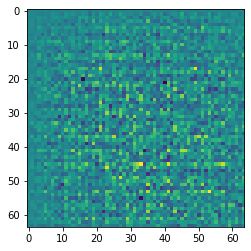

In [34]:
def build_generator_func_big(seed_size, embedding_size, channels):
    noise_input = layers.Input(shape=(seed_size,))
    embedding_input = layers.Input(shape=(embedding_size,))

    # Concatenate the noise and embedding inputs
    concatenated_inputs = layers.Concatenate()([noise_input, embedding_input])

    # Project and reshape the inputs
    x = layers.Dense(4 * 4 * 256)(concatenated_inputs)
    x = layers.Reshape((4, 4, 256))(x)

    # Block 1
    x = layers.Conv2DTranspose(128, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Block 2
    x = layers.Conv2DTranspose(64, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Block 3
    x = layers.Conv2DTranspose(32, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Output block
    output = layers.Conv2DTranspose(channels, 5, strides=2, padding="same", activation="tanh")(x)

    return tf.keras.models.Model([noise_input, embedding_input], output)


def build_discriminator_func_big(input_shape, embedding_size):
    image_input = layers.Input(shape=input_shape)
    embedding_input = layers.Input(shape=(embedding_size,))

    # Block 1
    x = layers.Conv2D(64, 5, strides=2, padding="same")(image_input)
    x = layers.LeakyReLU()(x)

    # Block 2
    x = layers.Conv2D(128, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Block 3
    x = layers.Conv2D(256, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Concatenate with the embedding input
    x = layers.Concatenate()([x, embedding_input])

    # Output block
    output = layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.models.Model([image_input, embedding_input], output)


# Build the generator and discriminator models
generator = build_generator_func_big(SEED_SIZE, EMBEDDING_SIZE, IMAGE_CHANNELS)
discriminator = build_discriminator_func_big((64, 64, IMAGE_CHANNELS), EMBEDDING_SIZE)

noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,200)), training=False)
plt.imshow(generated_image[0, :, :, 0])

In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) + 
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
    # print(gen_loss)
    # print(disc_loss)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [30]:
def save_images(cnt,noise,embeds):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = "./Data/datasets/output"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [41]:
def test_image(text,num):
    test_embeddings = np.zeros((1,200),dtype=np.float32)

    x = text.lower()
    x = x.replace(" ","")
    count = 0
    for t in x:
        try:
            test_embeddings[0] += glove_model[t]
            count += 1
        except:
            #print(t)
            pass
    #print(test_embeddings)
    if count != 0:
        test_embeddings[0] /= count
    else:
        return
    test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
    noise = tf.random.normal([28, 100])
    save_images(num,noise,test_embeddings)

In [42]:
generator1.load_weights("C:/Users/HP/Desktop/project/Gan/text_to_image_generator_cub_character.h5")
discriminator1.load_weights("C:/Users/HP/Desktop/project/Gan/text_to_image_disc_cub_character.h5")

1/1 [==============================] - 0s 206ms/step


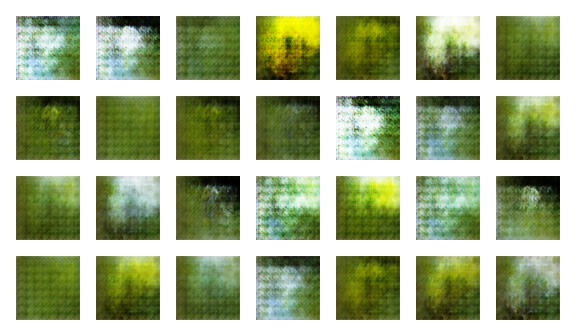

In [43]:
test_image("this flower is red in color with oval shaped petals", 1)
IPython.display.Image('./Data/datasets/output/train-1.png')

In [44]:
generator2.load_weights("C:/Users/HP/Desktop/project/AttnGan/text_to_image_generator_attn_character.h5")
discriminator2.load_weights("C:/Users/HP/Desktop/project/AttnGan/text_to_image_disc_attn_character.h5")

1/1 [==============================] - 0s 46ms/step


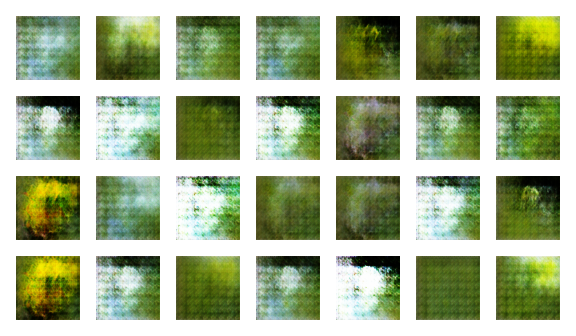

In [45]:
test_image("this flower is red in color with oval shaped petals", 1)
IPython.display.Image('./Data/datasets/output/train-1.png')

In [37]:
generator.load_weights("C:/Users/HP/Desktop/project/BigGan/2500/text_to_image_generator_biggan_character.h5")
discriminator.load_weights("C:/Users/HP/Desktop/project/BigGan/2500/text_to_image_disc_biggan_character.h5")